1.Import Corpus

In [4]:
import re
import csv
import pandas as pd
import nltk
import datetime
import numpy as np
import os
import string
from collections import Counter
from nltk.corpus import PlaintextCorpusReader
import matplotlib.pyplot as plt
%matplotlib inline  

In [5]:
import random
from nltk.corpus import movie_reviews
from textblob.classifiers import NaiveBayesClassifier
import math
from textblob import TextBlob as tb
from nltk.corpus import stopwords
from nltk.corpus import reuters
import textblob
from os import path
from nltk.tag import PerceptronTagger
from nltk.data import find

In [10]:
import itertools as it
import networkx as nx
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
%config InlineBackend.figure_format = 'png'

In [69]:
corpus_root = 'chinadaily'
chinadaily = PlaintextCorpusReader(corpus_root, '.*',encoding='utf-8')

In [8]:
corpus_root = 'nytimes'
nytimes= PlaintextCorpusReader(corpus_root, '.*',encoding='utf-8') 

2.Files Level Analysis

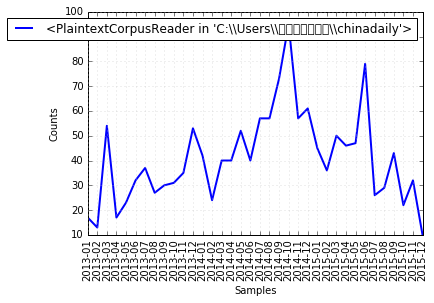

In [17]:
cdcfd = nltk.ConditionalFreqDist(
    (chinadaily,fileid[:7])
    for fileid in chinadaily.fileids())
cdcfd.plot()

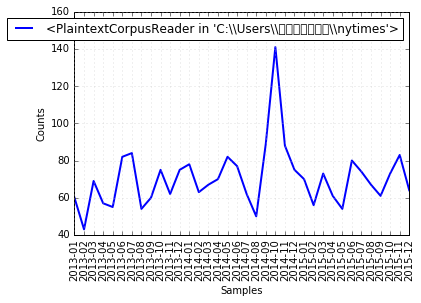

In [13]:
nycfd = nltk.ConditionalFreqDist(
    (nytimes,fileid[:7])
    for fileid in nytimes.fileids())
nycfd.plot()

3.[Words,Files] Analysis

In [21]:
#because country have multiple names, design a string method that can match all the right ones but exclude possible wrong ones
target='EUEurope'
w='rope'
target.startswith(w) or (target.endswith(w) and len(w)>4)

False

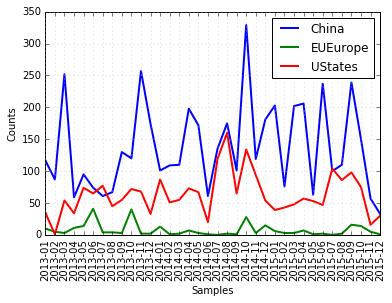

In [22]:
os.chdir('chinadaily')   #go to corpus
cfd = nltk.ConditionalFreqDist(
    (target, fileid[:7])
    for fileid in chinadaily.fileids()
    if os.path.getsize(fileid) > 0   # check the filesize is not 0
    for w in chinadaily.words(fileid)
    for target in ['UStates','China','EUEurope']  #'US' is a term used by China Daily a lot
    if target.startswith(w) or (target.endswith(w) and len(w)>4))
#back to parent directory
os.chdir("..")
cfd.plot()

as a comparison, if we only match US with "States"

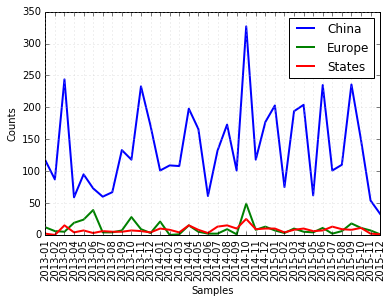

In [23]:
os.chdir('chinadaily')   #go to corpus
cfd1 = nltk.ConditionalFreqDist(
    (target, fileid[:7])
    for fileid in chinadaily.fileids()
    if os.path.getsize(fileid) > 0   # check the filesize is not 0
    for w in chinadaily.words(fileid)
    for target in ['States','China','Europe']  
    if w.startswith(target))
#back to parent directory
os.chdir("..")
cfd1.plot()

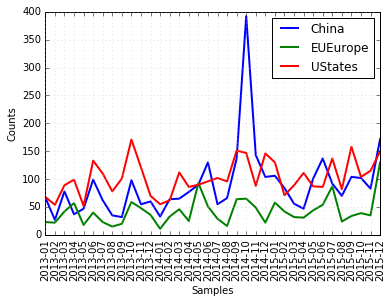

In [24]:
os.chdir('nytimes')
cfd = nltk.ConditionalFreqDist(
    (target, fileid[:7])
    for fileid in nytimes.fileids()
    if os.path.getsize(fileid) > 0   # check the filesize is not 0
    for w in nytimes.words(fileid)
    for target in ['UStates','China','EUEurope']  
    if target.startswith(w) or (target.endswith(w) and len(w)>4))
#back to parent directory
os.chdir("..")
cfd.plot()

4.Words Level Analysis

4.1 Words Frequency

In [25]:
cdraw=chinadaily.raw()

In [30]:
cdtokens = nltk.word_tokenize(cdraw)

In [181]:
cdnopun = [w for w in cdtokens if not w in string.punctuation]
stop = set(stopwords.words('english')) #use set to enormously decrease computation time
cdclean = [w for w in cdnopun if not w.lower() in stop]

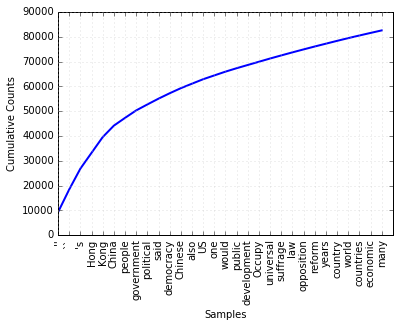

In [182]:
cdfd = nltk.FreqDist(word for word in cdclean)
cdfd.plot(30, cumulative=True)

In [34]:
nyraw=nytimes.raw()
nytokens = nltk.word_tokenize(nyraw)

In [183]:
nynopun = [w for w in nytokens if not w in string.punctuation]
stop = set(stopwords.words('english')) #use set to enormously decrease computation time
nyclean = [w for w in nynopun if not w.lower() in stop]

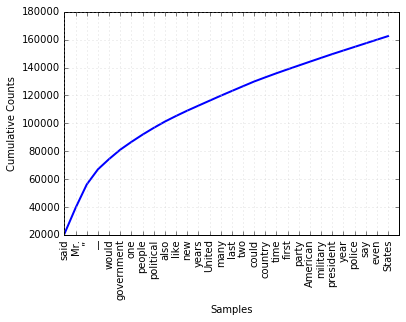

In [184]:
nyfd = nltk.FreqDist(word for word in nyclean)
nyfd.plot(30, cumulative=True)

4.2 TF-IDF

4.2.1 Prepare Testing Data

In [37]:
def tf(word, doc):
    return doc.words.count(word) / len(doc.words)

def n_containing(word, doclist):
    return sum(1 for doc in doclist if word in doc)

def idf(word, doclist):
    return math.log(len(doclist) / (1 + n_containing(word, doclist)))

def tfidf(word, doc, doclist):
    return tf(word, doc) * idf(word, doclist)

In [38]:
#use the textblob module to calculate tf-idf
ny=tb(nytimes.raw())
cd=tb(chinadaily.raw())

In [192]:
nopun = [w for w in ny.words if not w in string.punctuation]
stop = set(stopwords.words('english')) #use set to enormously decrease computation time
nostop = [w for w in nopun if not w.lower() in stop]
nostopfd = nltk.FreqDist(w for w in nostop)
mostnostop = [w for (w,v) in nostopfd.most_common(100)] #retrive only 100 most common words for testing candidates
nytest=mostnostop

In [193]:
nopun = [w for w in cd.words if not w in string.punctuation]
stop = set(stopwords.words('english')) 
nostop = [w for w in nopun if not w.lower() in stop]
nostopfd = nltk.FreqDist(w for w in nostop)
mostnostop = [w for (w,v) in nostopfd.most_common(100)] 
cdtest=mostnostop

4.2.2 Prepare Training Data

In [40]:
train=[]
#use reuters corpus as training data,randomly select 1000 news to reduce computation time
fileids=reuters.fileids()
random.shuffle(fileids)
for fileid in fileids[:1000]:
    doc=tb(reuters.raw(fileid))
    train.append(doc)

4.2.3 Modelling

In [187]:
scores = {word: tfidf(word, ny, train) for word in set(nytest)}
sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [188]:
for word, score in sorted_words[:30]:
    print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

	Word: said, TF-IDF: 0.05228
	Word: Mr, TF-IDF: 0.04713
	Word: ”, TF-IDF: 0.0421
	Word: —, TF-IDF: 0.02709
	Word: would, TF-IDF: 0.01861
	Word: government, TF-IDF: 0.01696
	Word: one, TF-IDF: 0.01513
	Word: new, TF-IDF: 0.01454
	Word: New, TF-IDF: 0.01454
	Word: people, TF-IDF: 0.01351
	Word: political, TF-IDF: 0.0123
	Word: also, TF-IDF: 0.01142
	Word: President, TF-IDF: 0.01104
	Word: president, TF-IDF: 0.01104
	Word: like, TF-IDF: 0.01031
	Word: party, TF-IDF: 0.01016
	Word: Party, TF-IDF: 0.01016
	Word: many, TF-IDF: 0.00969
	Word: last, TF-IDF: 0.00914
	Word: United, TF-IDF: 0.0091
	Word: years, TF-IDF: 0.00903
	Word: two, TF-IDF: 0.00893
	Word: state, TF-IDF: 0.00886
	Word: could, TF-IDF: 0.0085
	Word: States, TF-IDF: 0.00798
	Word: time, TF-IDF: 0.00756
	Word: country, TF-IDF: 0.00753
	Word: first, TF-IDF: 0.00734
	Word: even, TF-IDF: 0.00707
	Word: democracy, TF-IDF: 0.00706


In [194]:
scorec = {word: tfidf(word, cd, train) for word in set(cdtest)}
sorted_wordc = sorted(scorec.items(), key=lambda x: x[1], reverse=True)

In [197]:
for word, score in sorted_wordc[:30]:
    print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

	Word: 's, TF-IDF: 0.07201
	Word: Hong, TF-IDF: 0.05461
	Word: Kong, TF-IDF: 0.05449
	Word: China, TF-IDF: 0.03968
	Word: People, TF-IDF: 0.03291
	Word: people, TF-IDF: 0.03291
	Word: government, TF-IDF: 0.0269
	Word: democracy, TF-IDF: 0.02181
	Word: political, TF-IDF: 0.02177
	Word: said, TF-IDF: 0.02007
	Word: Law, TF-IDF: 0.01847
	Word: law, TF-IDF: 0.01847
	Word: US, TF-IDF: 0.01815
	Word: one, TF-IDF: 0.01793
	Word: One, TF-IDF: 0.01793
	Word: Chinese, TF-IDF: 0.01759
	Word: central, TF-IDF: 0.01693
	Word: Central, TF-IDF: 0.01693
	Word: also, TF-IDF: 0.01591
	Word: would, TF-IDF: 0.0132
	Word: public, TF-IDF: 0.01278
	Word: country, TF-IDF: 0.01269
	Word: development, TF-IDF: 0.01244
	Word: two, TF-IDF: 0.01162
	Word: Occupy, TF-IDF: 0.01158
	Word: universal, TF-IDF: 0.01155
	Word: new, TF-IDF: 0.01118
	Word: world, TF-IDF: 0.01116
	Word: suffrage, TF-IDF: 0.01077
	Word: opposition, TF-IDF: 0.01046


5.Content Analysis

5.1 Sentiment Anlaysis

5.1.1 Training

In [53]:
#firslt, design training data from movie_reviews
all_words = [w.lower() for w in movie_reviews.words()]

In [54]:
nopun = [w for w in all_words if not w in string.punctuation]

In [55]:

stop = set(stopwords.words('english'))
nostop = [w for w in nopun if not w in stop]

In [56]:
nostopfd = nltk.FreqDist(w for w in nostop)
mostnostop = set([w for (w,v) in nostopfd.most_common(1000)])


In [57]:
list=[]
for fileid in movie_reviews.fileids():
    keywords=[w for w in movie_reviews.words(fileid) if w in mostnostop]
    tag=fileid[:3]
    list.append((keywords,tag))

In [58]:
random.shuffle(list)
train=list[:1000]

In [59]:
test=list[1000:]

In [60]:
from textblob.classifiers import NaiveBayesClassifier as NB
cl=NB(train)

In [61]:
cl.show_informative_features(15)

Most Informative Features
    contains(ridiculous) = True              neg : pos    =      8.0 : 1.0
        contains(stupid) = True              neg : pos    =      5.5 : 1.0
         contains(awful) = True              neg : pos    =      5.1 : 1.0
         contains(worst) = True              neg : pos    =      5.1 : 1.0
          contains(dull) = True              neg : pos    =      4.9 : 1.0
         contains(waste) = True              neg : pos    =      4.0 : 1.0
        contains(boring) = True              neg : pos    =      3.8 : 1.0
      contains(terrible) = True              neg : pos    =      3.6 : 1.0
          contains(mess) = True              neg : pos    =      3.5 : 1.0
       contains(complex) = True              pos : neg    =      3.4 : 1.0
        contains(murphy) = True              pos : neg    =      3.3 : 1.0
     contains(perfectly) = True              pos : neg    =      3.2 : 1.0
        contains(batman) = True              neg : pos    =      3.1 : 1.0

In [62]:
#use the rest of movie reviews data to test for accuracy
cl.accuracy(test)

0.809

5.1.2 Testing

In [63]:
tags=[]
os.chdir('nytimes')   #go to corpus
for fileid in nytimes.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'China' in nytimes.words(fileid): 
            blob=tb(nytimes.raw(fileid),classifier=cl)
            tag=blob.classify()
            tags.append(tag)
#back to parent directory
os.chdir("..")

In [64]:
nychina=Counter(tags)

In [108]:
tags2=[]
os.chdir('nytimes')   #go to corpus
for fileid in nytimes.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'Europe' in nytimes.words(fileid): 
            blob=tb(nytimes.raw(fileid),classifier=cl)
            tag=blob.classify()
            tags2.append(tag)
#back to parent directory
os.chdir("..")

In [109]:
nyeurope=Counter(tags2)

In [112]:
tags4=[]
os.chdir('nytimes')   #go to corpus
for fileid in nytimes.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'States' in nytimes.words(fileid): 
            blob=tb(nytimes.raw(fileid),classifier=cl)
            tag=blob.classify()
            tags4.append(tag)
#back to parent directory
os.chdir("..")

In [113]:
nyus=Counter(tags4)

In [114]:
tagc=[]
os.chdir('chinadaily')   #go to corpus
for fileid in chinadaily.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'US' in chinadaily.words(fileid): 
            blob=tb(chinadaily.raw(fileid),classifier=cl)
            tag=blob.classify()
            tagc.append(tag)
#back to parent directory
os.chdir("..")

In [115]:
cdus=Counter(tagc)

In [116]:
tagc2=[]
os.chdir('chinadaily')   #go to corpus
for fileid in chinadaily.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'China' in chinadaily.words(fileid): 
            blob=tb(chinadaily.raw(fileid),classifier=cl)
            tag=blob.classify()
            tagc2.append(tag)
#back to parent directory
os.chdir("..")

In [117]:
cdchina=Counter(tagc2)

In [118]:
tagc3=[]
os.chdir('chinadaily')   #go to corpus
for fileid in chinadaily.fileids():
    if os.path.getsize(fileid) > 0:   # check the filesize is not 0
        if 'Europe' in chinadaily.words(fileid): 
            blob=tb(chinadaily.raw(fileid),classifier=cl)
            tag=blob.classify()
            tagc3.append(tag)
#back to parent directory
os.chdir("..")

In [119]:
cdeurope=Counter(tagc3)

In [120]:
def plotcounter(counter):
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    performance = [counter[k] for k in keys]
    error = np.random.rand(len(keys))

    plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
    plt.yticks(y_pos, keys)
    plt.xlabel(counter)
    plt.title('number of articles')
    return plt.show()

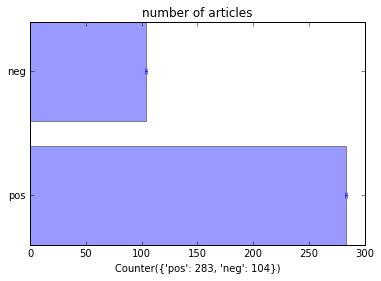

In [126]:
plotcounter(cdchina)
plotcounter(cdus)
plotcounter(cdeurope)
plotcounter(nychina)
plotcounter(nyus)
plotcounter(nyeurope)

5.2 Network of Nouns

In [2]:
#It seems that NLTK 3.2 has a bug with pos_tag module (AP_MODEL_LOC line), the following code fix it temporarily
from nltk.tag import PerceptronTagger
from nltk.data import find
PICKLE = "averaged_perceptron_tagger.pickle"
AP_MODEL_LOC = 'file:'+str(find('taggers/averaged_perceptron_tagger/'+PICKLE))
tagger = PerceptronTagger(load=False)
tagger.load(AP_MODEL_LOC)
pos_tag = tagger.tag

In [3]:
#store relevant files into a new dirctory, read the new corpus with the categorized corpus reader
corpus_root='hk'
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
hk = CategorizedPlaintextCorpusReader(corpus_root,r'\w*/.*', cat_pattern=r'(\w*)/.*',encoding='utf-8') 

5.2.1 China Daily

In [34]:
cdhktokens=hk.words(categories='ChinaDaily')
cdhknopun = [w for w in cdhktokens if not w in (string.punctuation)]
stopword = stopwords.words('english')+['.', ',', '"', "'", '-','!','<','>','.-', '".', '/', '."','".', ',"', '",', '@', '-"','"-',"'[", "']",'("','")','"(',')"','?"','"?'] +['kong','hk','page']
cdhkclean = [w for w in cdhknopun if not w.lower() in stopword]

In [104]:
cdhkfd=nltk.FreqDist(cdhkclean)
cdhkmf=[token for token,count in cdhkfd.most_common(100)]
sents=[[token.lower() for token in sent if token in cdhkmf] 
               for sent in hk.sents(categories='ChinaDaily')]
tagged_sents = [pos_tag(sentence) for sentence in sents]
noun_phrases = [[token for token, tag in sent if re.match(r'NN', tag)] for sent in tagged_sents]

In [105]:
edgelist = [edge for phrase in noun_phrases for edge in it.combinations(phrase, 2)]
print(len(edgelist))
G = nx.Graph(edgelist)
index = nx.betweenness_centrality(G)

2619


In [106]:
sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
sorted_index[:20]

[('government', 0.09383870233616756),
 ('democracy', 0.06126627254304875),
 ('law', 0.04626091599717654),
 ('hong', 0.04019660894084554),
 ('people', 0.03537331368875855),
 ('city', 0.0324962087399558),
 ('protesters', 0.03097717318374742),
 ('movement', 0.027924681632129952),
 ('suffrage', 0.023493496292269444),
 ('opposition', 0.020470687013107024),
 ('executive', 0.016837198851216074),
 ('campaign', 0.015774670895112797),
 ('reform', 0.015430482338353457),
 ('protest', 0.013988882865073283),
 ('protests', 0.01395245646168982),
 ('students', 0.011897922666435124),
 ('time', 0.010705076202490112),
 ('residents', 0.010472132967768326),
 ('business', 0.01044197184801454),
 ('china', 0.00929344679794212)]

In [107]:
%matplotlib auto
plt.rc('figure', figsize=(24, 14))
G.remove_nodes_from([n for n in index if index[n] == .0])
node_size = [index[n]*10000 for n in G]
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size=node_size, edge_color='b', alpha=.4, linewidths=0)

Using matplotlib backend: Qt4Agg


5.2.2 Nytimes

In [7]:
nyhktokens=hk.words(categories='Nytimes')
nyhknopun = [w for w in nyhktokens if not w in (string.punctuation)]
stopword = stopwords.words('english')+['—' ,'’','”', '“','.”','.“','‘','.”“', ',”','"', "'", '-','!','<','>','.-', '".', '/', '."','".', ',"', '",', '@', '-"','"-',"'[", "']",'("','")','"(',')"','?"','"?'] +['kong','hk','page']
nyhkclean = [w for w in nyhknopun if not w.lower() in stopword]

In [98]:
nyhkfd=nltk.FreqDist(nyhkclean)
nyhkmf=[token for token,count in nyhkfd.most_common(80)]
sents2=[[token.lower() for token in sent if token in nyhkmf] 
               for sent in hk.sents(categories='Nytimes')]
tagged_sents2 = [pos_tag(sentence) for sentence in sents2]
noun_phrases2 = [[token for token, tag in sent if re.match(r'NN', tag)] for sent in tagged_sents2]

In [99]:
edgelist2 = [edge for phrase in noun_phrases2 for edge in it.combinations(phrase, 2)]
print(len(edgelist2))
G2 = nx.Graph(edgelist2)
index2 = nx.betweenness_centrality(G2)
sorted_index2 = sorted(index2.items(), key=lambda x:x[1], reverse=True)
sorted_index2[:20]

14150


[('police', 0.020651416398688067),
 ('years', 0.0171706582346689),
 ('protesters', 0.013579490035828192),
 ('hong', 0.010447425597030277),
 ('democracy', 0.010209837089904061),
 ('people', 0.009927351214197848),
 ('elections', 0.00945733703389804),
 ('mr', 0.009226956231338658),
 ('government', 0.008464767135580293),
 ('movement', 0.008326847625010843),
 ('demands', 0.00771323782387993),
 ('leung', 0.00771270648293353),
 ('executive', 0.007169309594001859),
 ('protests', 0.006746022185411194),
 ('students', 0.006250497173365111),
 ('groups', 0.005204677745816815),
 ('night', 0.00518384867688335),
 ('time', 0.005160641077240635),
 ('beijing', 0.005055135748341023),
 ('demonstrators', 0.004928720551481672)]

In [100]:
%matplotlib auto
plt.rc('figure', figsize=(24, 14))
G2.remove_nodes_from([n for n in index2 if index2[n] == .0])
node_size = [index2[n]*10000 for n in G2]
pos = nx.spring_layout(G2)
nx.draw_networkx(G2, pos, node_size=node_size, edge_color='b', alpha=.4, linewidths=0)

Using matplotlib backend: Qt4Agg
